# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [4]:
import os
import io
import requests
import numpy as np
from scipy import stats
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 6

## Helpers
# generate straight line
straight_line = lambda y, xs: ([xs[0], xs[-1]], [y, y])
# normalize values by mean and std
norm = lambda x: (np.array(x) - np.nanmean(x)) / np.std(x)

In [5]:
# from IPython.display import Image
# Image(filename = "Ridetypes.png")

In [6]:
card_types = np.array([
    '10 Trip',
    '14 Day',
    '1 Day/Funpass',
    '2 Trip',
    '30 Day',
    '7 Day',
    'Americans with Disability Act',
    'ADA Farecard Access System',
    'Express',
    'Easy Pay',
    'Full Fare',
    'Metrocard',
    'Mail and Ride',
    'Monthly',
    'Reduced Fare Media',
    'Rail Road',
    'Senior Citizen/Disabled',
    'Special',
    'Transit Check Metrocard',
    'Ticket',
    'Unlimited',
    'Express Bus',
    'Student Usage'
])

card_map = {k: i for i, k in enumerate(card_types)}
station_names = ['Station {}'.format(i) for i in range(600)]
len(card_types) # didn't miss any!

23

In [7]:
# get weekly dates starting 5/21/2010 and ending 2/21/2014
start_date = datetime(2010, 5, 21)
end_date = datetime(2014, 2, 21)
sample_period = timedelta(weeks=1)
dates = [
    start_date + i*sample_period 
    for i in range(int((end_date - start_date) / sample_period) + 1)
]

# Not sure why there are 197 weeks... I think your date range is off perhaps
dates = dates[:194]

# Checking date range
dates[:3], '...', dates[-3:], len(dates)

([datetime.datetime(2010, 5, 21, 0, 0),
  datetime.datetime(2010, 5, 28, 0, 0),
  datetime.datetime(2010, 6, 4, 0, 0)],
 '...',
 [datetime.datetime(2014, 1, 17, 0, 0),
  datetime.datetime(2014, 1, 24, 0, 0),
  datetime.datetime(2014, 1, 31, 0, 0)],
 194)

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




In [8]:
url = 'https://github.com/fedhere/PUI2017_fb55/raw/master/HW10_fb55/MTA_Fare.npy'
fname = os.path.join(os.getenv('PUIDATA'), os.path.basename(url))

# Load data
if os.path.isfile(fname):
    print('from puidata.')
    data = np.load(fname)
else:
    print('from github.')
    data = requests.get(url).content
    with open(fname, 'wb') as f:
        f.write(data)
    data = np.load(io.BytesIO(data))
data.shape

from github.


(600, 23, 194)

In [9]:
# Convert -1 to nans
data = data.astype(float)
data[data == -1] = np.nan
data.shape, '{:.2f}% nan'.format(np.isnan(data).sum() / data.size * 100)

((600, 23, 194), '24.26% nan')

In [10]:
# precompute totals for each card, station, and overall
card_data = np.nansum(data, axis=0)
station_data = np.nansum(data, axis=1)
summed_data = np.nanmean(np.nanmean(data, axis=0), axis=0)

station_data.shape, card_data.shape, summed_data.shape

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


((600, 194), (23, 194), (194,))

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [11]:
def event_detection(fares):
    '''Detect event by getting the # standard deviations from the mean'''
    return np.abs(norm(fares))

# Detect largest events
events = event_detection(summed_data)

print('Top 10 Events')
sorted(
    zip(dates, events, range(194)), 
    key=lambda a: a[1]
)[::-1][:10]

Top 10 Events


[(datetime.datetime(2012, 10, 19, 0, 0), 8.7485734610013193, 126),
 (datetime.datetime(2010, 12, 24, 0, 0), 2.666728562730031, 31),
 (datetime.datetime(2010, 12, 17, 0, 0), 2.6643303650395236, 30),
 (datetime.datetime(2012, 12, 14, 0, 0), 2.4587664174315464, 134),
 (datetime.datetime(2011, 8, 19, 0, 0), 2.1990973354471199, 65),
 (datetime.datetime(2012, 3, 16, 0, 0), 2.1339697555204893, 95),
 (datetime.datetime(2011, 9, 16, 0, 0), 2.0688346245911626, 69),
 (datetime.datetime(2011, 12, 16, 0, 0), 2.0121667022867076, 82),
 (datetime.datetime(2013, 12, 13, 0, 0), 1.9124832766169695, 186),
 (datetime.datetime(2013, 12, 6, 0, 0), 1.9092925461582471, 185)]

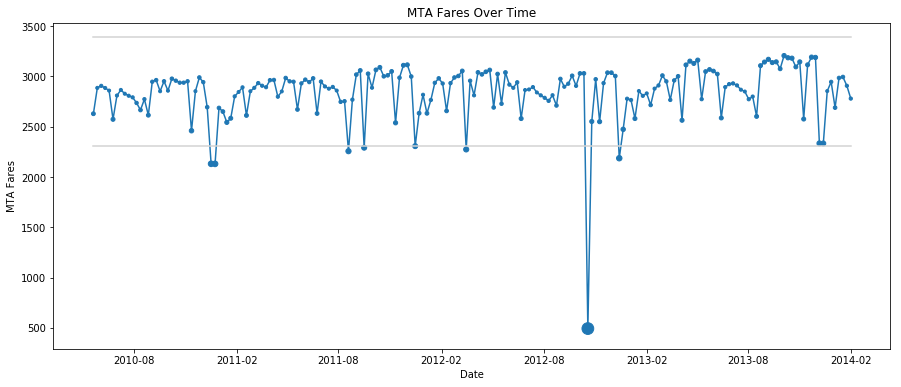

In [12]:
# Plot time series
plt.plot(dates, summed_data)
plt.scatter(dates, summed_data, s=(events+3)**2)
plt.title('MTA Fares Over Time')
plt.xlabel('Date')
plt.ylabel('MTA Fares')

# Plot 1 standard deviation
mu, sigma = np.nanmean(summed_data), np.std(summed_data)
plt.plot(*straight_line(mu - 2*sigma, dates), c='lightgrey')
plt.plot(*straight_line(mu + 2*sigma, dates), c='lightgrey');

### Figure 1: Time series for the sum of all station and card type fares. The size of the point represents the abnormality of the event, as measured by the number of standard deviations from the mean. This shows several smaller events with one large event, a dip down to 500, occuring at 10/19/2012. This is the week of Hurricane Sandy, which most certainly affected MTA traffic. The effect can be seen quite clearly here.

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [13]:
def moving_average(fares, window=None, n=10):
    '''Calculate the moving average using an arbitrary window (window normalized to sum to 1)
    Adds edge-value padding to get an equal length array without boundary effects
    '''
    window = window if window is not None else np.ones((n,))
    pad = (len(window) - 1) / 2
    return np.pad(
        np.convolve(fares, window / window.sum(), mode='valid'),
        np.array([np.ceil(pad), np.floor(pad)]).astype(int),
        mode='edge'
    )

# Create hamming window for moving average
window_size = 12
window = np.hamming(window_size)

# Smooth all card types -> (23, 194)
smoothed = np.apply_along_axis(moving_average, 1, card_data, window=window)

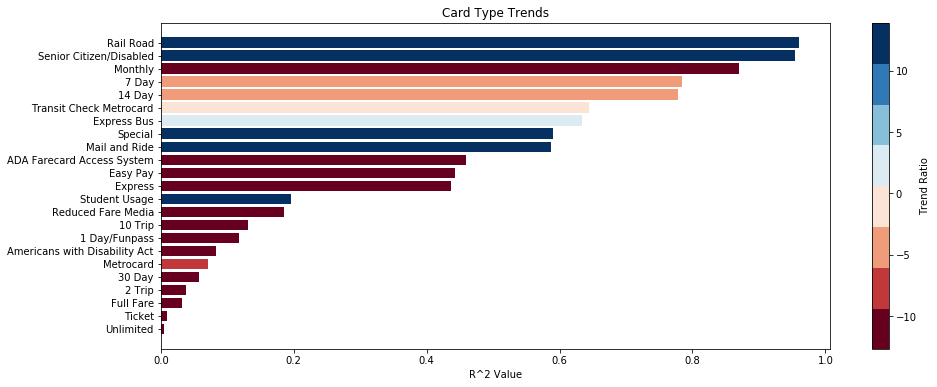

In [14]:
def trend_ratio(fares, n=10):
    '''Calculate the log ratio of the fares at the beginning and end of the period
        Adding 1 to avoid nonfinite values
    '''
    return np.log((np.nanmean(fares[-n:]) + 1) / (np.nanmean(fares[:n]) + 1))

def linear_trend_score(fares):
    '''Return the R^2 score of the fares (assumed to be equally spaced)'''
    m, b, r, p, err = stats.linregress(range(len(fares)), fares)
    return r**2

# get start/end ratios for each card type -> (23,)
trend_ratio = np.apply_along_axis(trend_ratio, 1, smoothed)
trend_ratio[~np.isfinite(trend_ratio)] = np.nan

# get r^2 for each card type -> (23,)
linear_trends = np.apply_along_axis(linear_trend_score, 1, smoothed)

# Sort the indices by trend ratio -> (23,)
sorted_trends = np.indices(linear_trends.shape).squeeze()[np.argsort(linear_trends)[::-1]]
cmap = mpl.cm.get_cmap('RdBu', 8)
ax = plt.scatter(trend_ratio, trend_ratio, c=trend_ratio, cmap=cmap)
plt.clf()
plt.colorbar(ax).ax.set_ylabel('Trend Ratio')
_x = np.arange(len(sorted_trends))[::-1]
plt.barh(_x, linear_trends[sorted_trends], color=cmap(trend_ratio[sorted_trends]) )
plt.xlabel('R^2 Value')
plt.yticks(_x, card_types[sorted_trends])
plt.title('Card Type Trends');

### Figure 2: Showing both the linear trend (R^2) and the direction (trend ratio) for each card type. R^2 value represents the degree to which the time series adheres to a simple linear trend, while the trend ratio gives an estimate of the overall change between the start and end of the time series. The strongest trends based on the described criteria above are the top three card types, Rail Road, Senior Citizen, and Monthly (increasing, increasing, and decreasing respectively), as they have both the top R^2 scores and have divergent trend ratios. 

In [15]:
for i in sorted_trends:
    print('{}: R2={:.2f}, ratio={:.2f}'.format(card_types[i], linear_trends[i], trend_ratio[i]))

Rail Road: R2=0.96, ratio=0.94
Senior Citizen/Disabled: R2=0.95, ratio=1.03
Monthly: R2=0.87, ratio=-0.53
7 Day: R2=0.78, ratio=0.34
14 Day: R2=0.78, ratio=0.26
Transit Check Metrocard: R2=0.64, ratio=0.48
Express Bus: R2=0.63, ratio=0.52
Special: R2=0.59, ratio=3.09
Mail and Ride: R2=0.59, ratio=9.99
ADA Farecard Access System: R2=0.46, ratio=-8.07
Easy Pay: R2=0.44, ratio=-12.68
Express: R2=0.44, ratio=-11.19
Student Usage: R2=0.20, ratio=13.94
Reduced Fare Media: R2=0.19, ratio=-0.44
10 Trip: R2=0.13, ratio=0.02
1 Day/Funpass: R2=0.12, ratio=0.12
Americans with Disability Act: R2=0.08, ratio=-0.13
Metrocard: R2=0.07, ratio=0.19
30 Day: R2=0.06, ratio=0.06
2 Trip: R2=0.04, ratio=-0.06
Full Fare: R2=0.03, ratio=-0.20
Ticket: R2=0.01, ratio=0.02
Unlimited: R2=0.01, ratio=-0.23


Trends for all Stations (y axis not to scale)


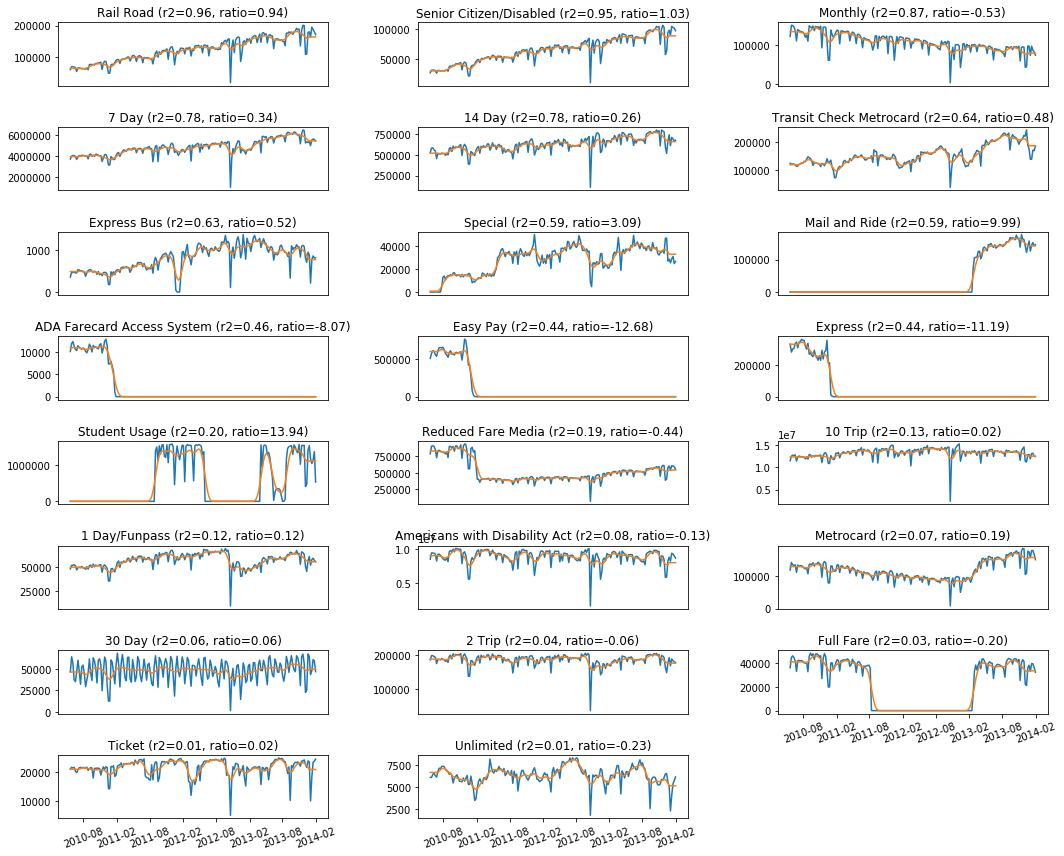

In [16]:
nrows = 3
plt.figure(figsize=(15,12))
for i, tnd in enumerate(sorted_trends, 1):
    plt.subplot(len(smoothed)//nrows+1, nrows, i)
    plt.plot(dates, card_data[tnd])
    plt.plot(dates, smoothed[tnd])
    plt.title('{} (r2={:.2f}, ratio={:.2f})'.format(card_types[tnd], linear_trends[tnd], trend_ratio[tnd]))
    
    if i <= len(smoothed) - nrows:
        plt.gca().get_xaxis().set_visible(False)
    else:
        plt.xticks(rotation=20)
plt.tight_layout()
print('Trends for all Stations (y axis not to scale)')

### Figure 3: All card types with both the raw waveform in blue and the smoothed version in yellow. This can be used to help visualize and understand the metrics from Figure 2 above. The three trends selected above fit the visual description of a steadily trending line, whereas multiple card types, including Full Fare and Student Usage contain large timespans with null values and do not fit the description.

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [17]:
# Compute frequency spacing and the closest frequency to annual
# NOTE: **DC offset was dropped** meaning freq[3] should properly be freq[4]
fs = np.fft.rfftfreq(station_data.shape[-1], d=1./52)[1:]
annual_idx = np.argmin(np.abs(fs - 1))
print('Closest to annual: freq[{}] = {:.3f} cycles per year'.format(annual_idx, fs[annual_idx]))

def calc_periodicity(fares):
    '''Get the power spectrum'''
    return np.abs(np.fft.rfft(fares))**2

# Get power spectrum for all stations -> (600, 194/2+1)
periodicity = np.apply_along_axis(calc_periodicity, 1, station_data)[:,1:]

# select periodicity at 52 weeks for each station -> (600,)
annual_periodicity = periodicity[:,annual_idx]
station_annual = np.argsort(annual_periodicity)[::-1]

print('Most Periodic Stations at Annual Frequency:')
for i, station in enumerate(station_annual[:10], 1):
    print('{}: Station {}'.format(i, station, annual_periodicity[station]))

Closest to annual: freq[3] = 1.072 cycles per year
Most Periodic Stations at Annual Frequency:
1: Station 0
2: Station 194
3: Station 150
4: Station 327
5: Station 32
6: Station 539
7: Station 19
8: Station 169
9: Station 56
10: Station 54


In [18]:
# Plot periodicity of all spectrums
for spec in periodicity:
    plt.plot(fs[2:], spec[2:])
    plt.plot(fs[annual_idx], spec[annual_idx], 'o', ms=4)

plt.title('Spectrum for All Stations')
plt.xlabel('Frequency (cycles/year)')
plt.ylabel('Power');

### Figure 4: The power spectrum for all stations. The points mark the annual frequency. There are 5 stations with large periodicity at the annual level compared to the rest of the spectra. These can be seen clearly by the four points all above y=1e10. 

In [19]:
# Output the most significant peaks
print('Top Peaks by Frequency: ')
for freq, power in sorted(zip(fs, np.max(periodicity, axis=0)), key=lambda a: a[1])[::-1][:5]:
    print('Power at {:.2f} cycles per year ({:.2f} year period): {:.2E}'.format(freq, 1/freq, power))

Top Peaks by Frequency: 
Power at 1.07 cycles per year (0.93 year period): 8.88E+12
Power at 0.27 cycles per year (3.73 year period): 7.20E+12
Power at 12.06 cycles per year (0.08 year period): 5.54E+12
Power at 0.54 cycles per year (1.87 year period): 4.83E+12
Power at 8.04 cycles per year (0.12 year period): 3.81E+12


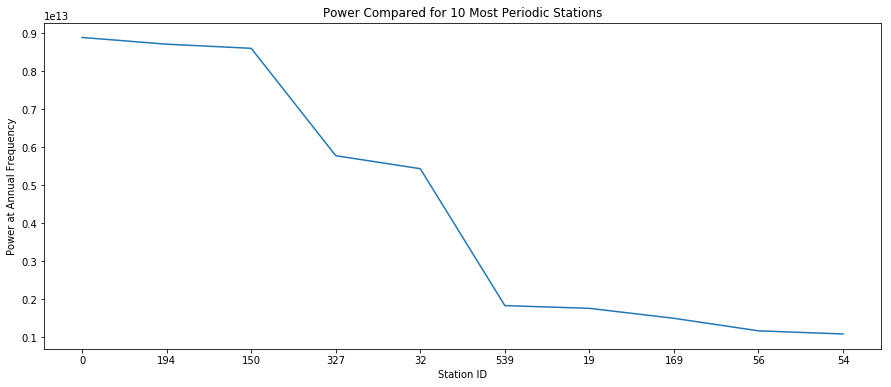

In [20]:
# Plot the power for the top 10 periodic stations
show_n = 10
plt.plot(annual_periodicity[station_annual[:show_n]])
plt.xticks(range(show_n), station_annual[:show_n])
plt.xlabel('Station ID')
plt.ylabel('Power at Annual Frequency')
plt.title('Power Compared for {} Most Periodic Stations'.format(show_n));

### FIgure 5: The power at the annual frequency for the top stations sorted by their power value. This shows a natural grouping of the stations by magnitude. The groups appear to be (by visual inspection), the first 3, the next two, and the rest. This gives a sense of the relative significance of each peak.

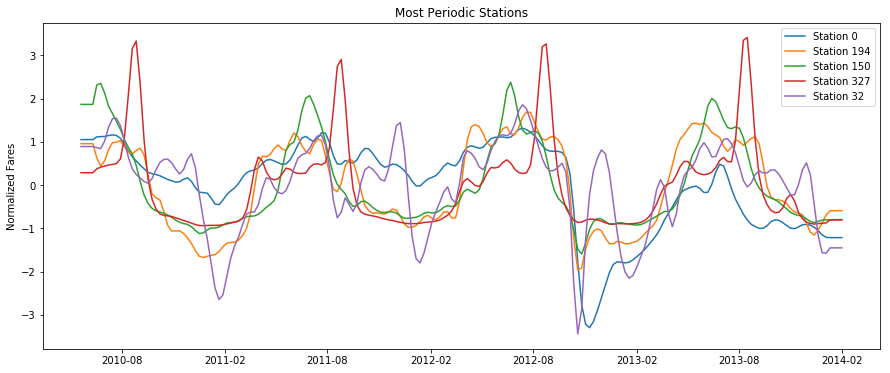

In [21]:
# Get the smoothed spectrum for all stations
smoothed_stations = np.apply_along_axis(moving_average, 1, station_data, window=np.hamming(7))

# Display the top 5 most periodic station
for i in station_annual[:5]:
    station = smoothed_stations[i,:]
    plt.plot(dates, norm(station), label='Station {}'.format(i))

plt.title('Most Periodic Stations')
plt.ylabel('Normalized Fares')
plt.legend();

### FIgure 6: The normalized (and smoothed) time series of the top 5 annually periodic stations. There is a remarkably clear periodicity that can be seen (is it weird to find it exciting?). The lack of any phase differences in the oscillations implies that they share a common cause, perhaps a seasonal trend where people are more inclined to travel to the city during the summer.

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

## Trying K Means in the recommended way

In [22]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [23]:
# Cleaning
data = np.load(fname)
cldata = data.reshape(-1, 194)
cldata = np.apply_along_axis(moving_average, 0, cldata, window=np.hamming(10))
cldata[~np.isfinite(cldata)] = 0
cldata = cldata[cldata.std(1) > 0]
cldata_norm = np.apply_along_axis(norm, 0, cldata)
cldata_norm.shape

(10936, 194)

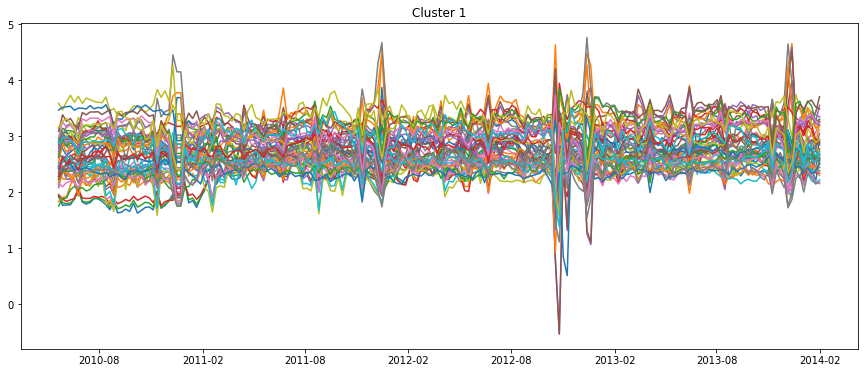

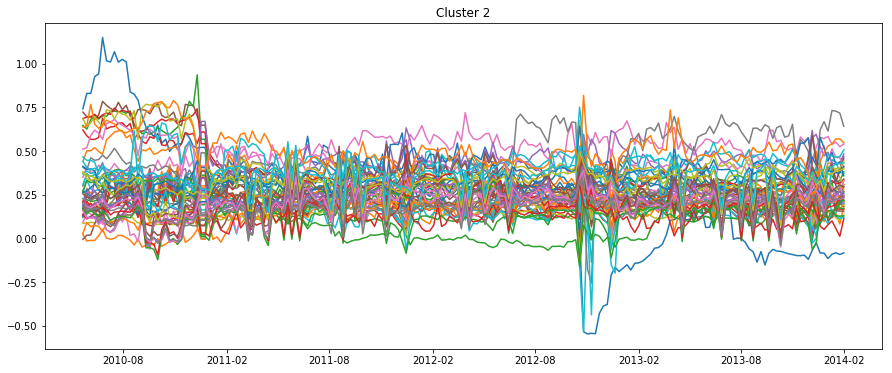

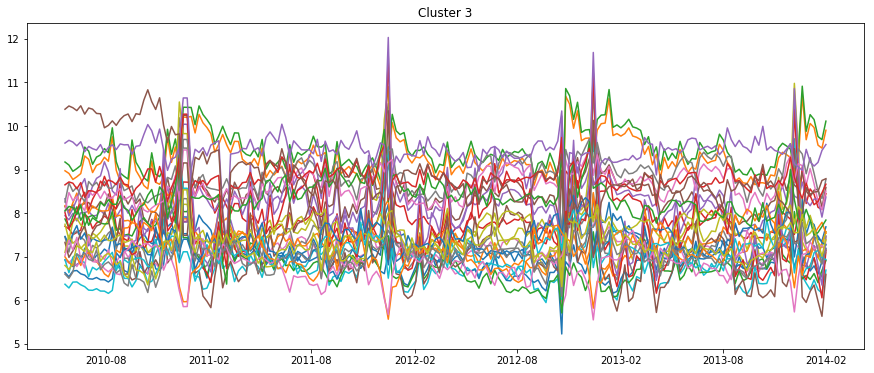

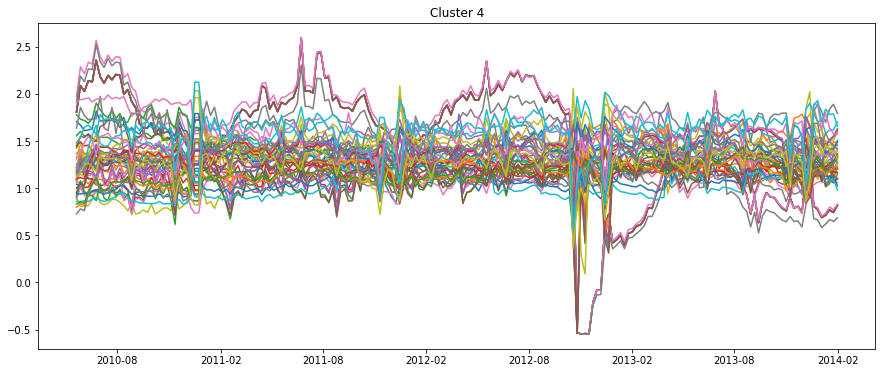

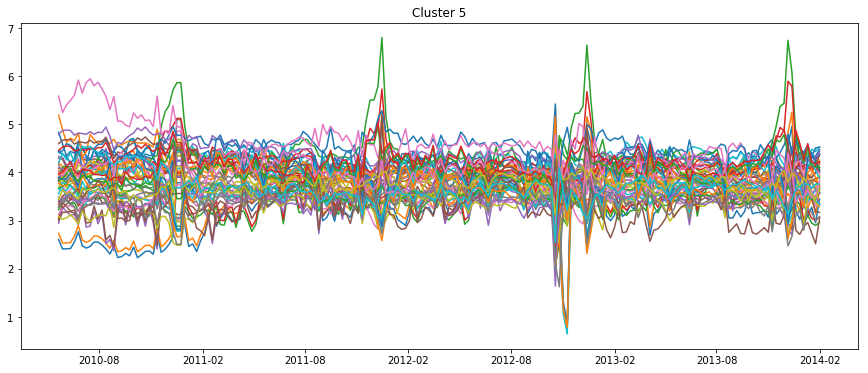

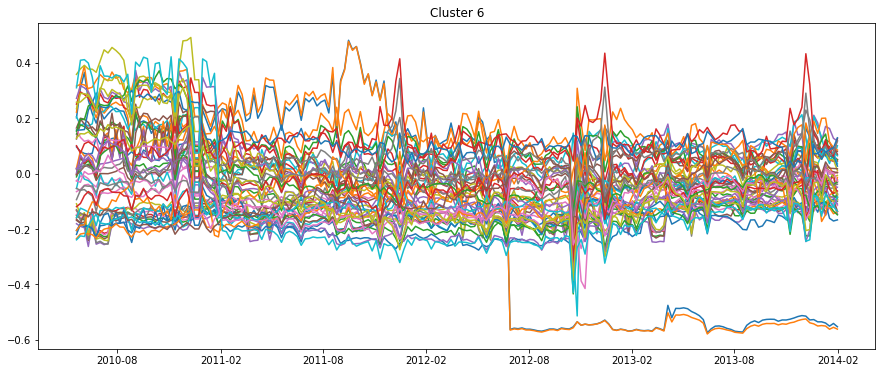

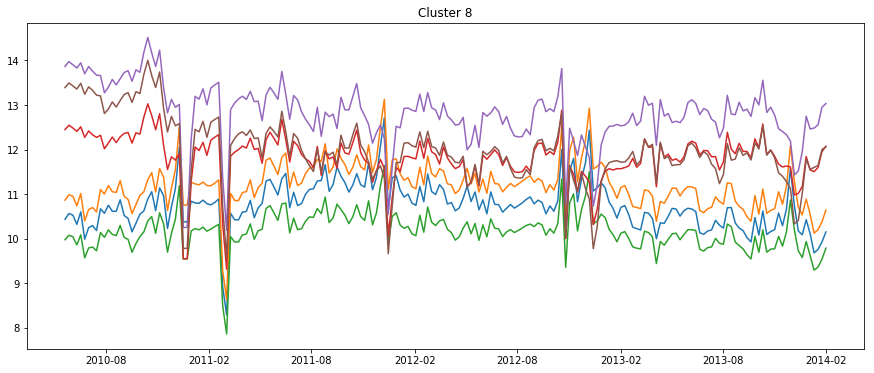

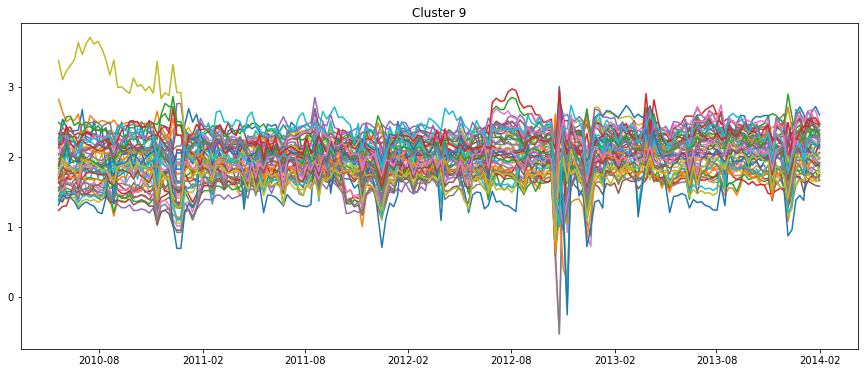

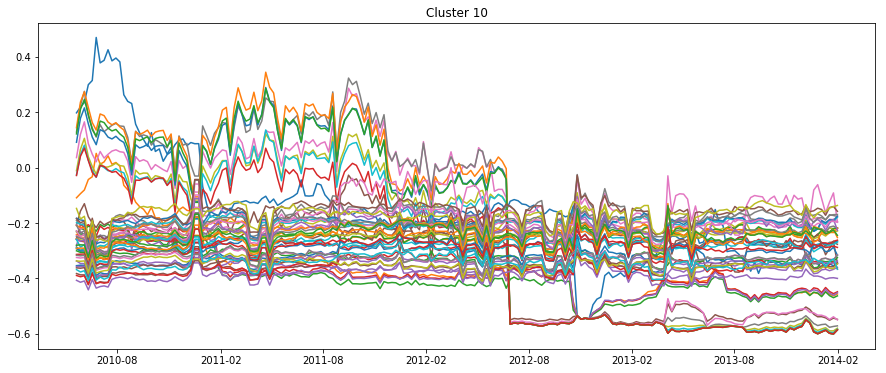

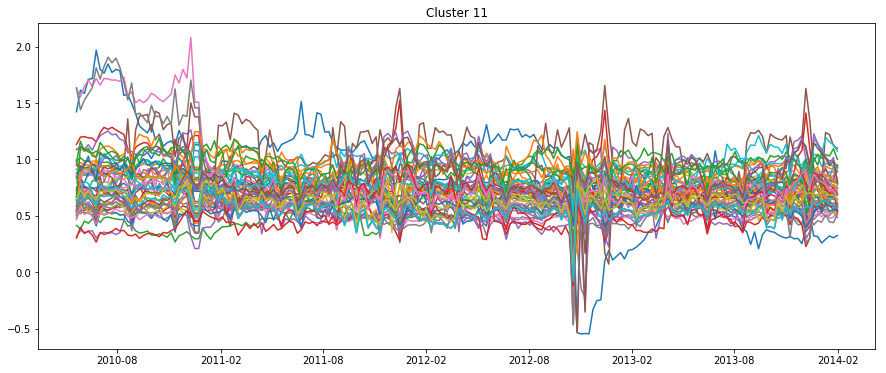

In [24]:
kmeans = KMeans(n_clusters=12)
classes = kmeans.fit_predict(cldata_norm)

for i in np.unique(classes):
    for s in cldata_norm[classes == i][:50]:
        plt.plot(dates, s)
    plt.title('Cluster {}'.format(i))
    plt.show()

### Figure 7: 12 clusters using raw time series data. I would say that this not a successful clustering. The best looking cluster is cluster 8 which appears to be correlated and have peaks and troughs occuring simultaneously, however, the part of the reason that it looks better than the others is that there are much fewer elements assigned to that cluster. Other clusters appear to be random and don't follow any perceptible patterns, though that could be the result of plotting so many lines at once.

## Now trying with the power spectrum

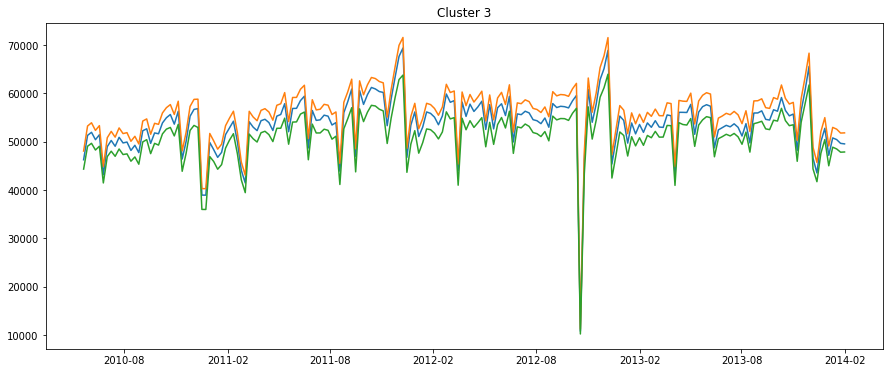

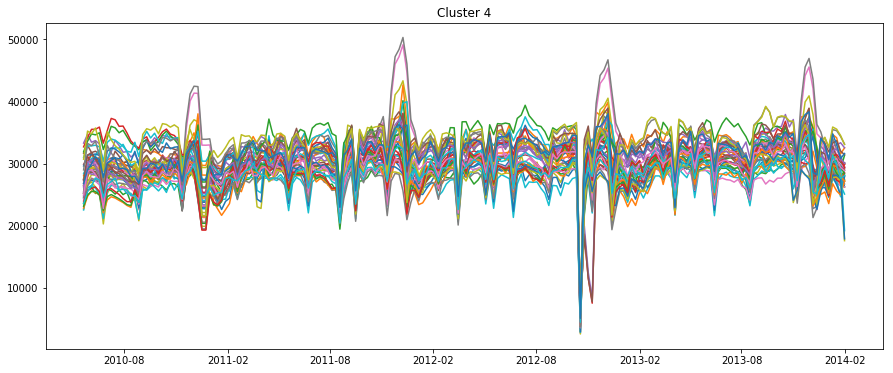

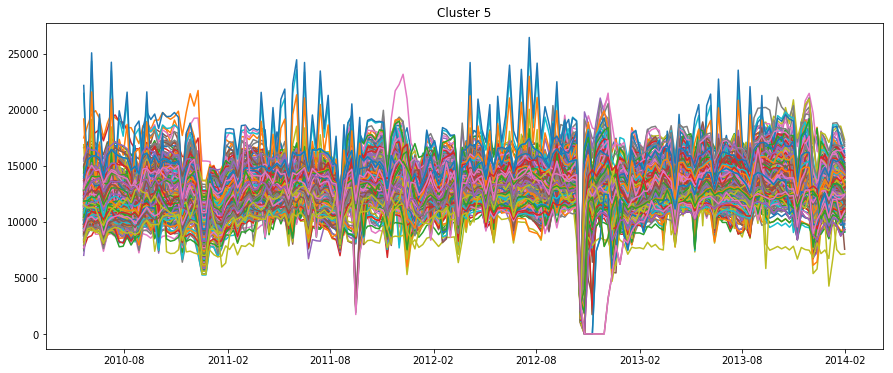

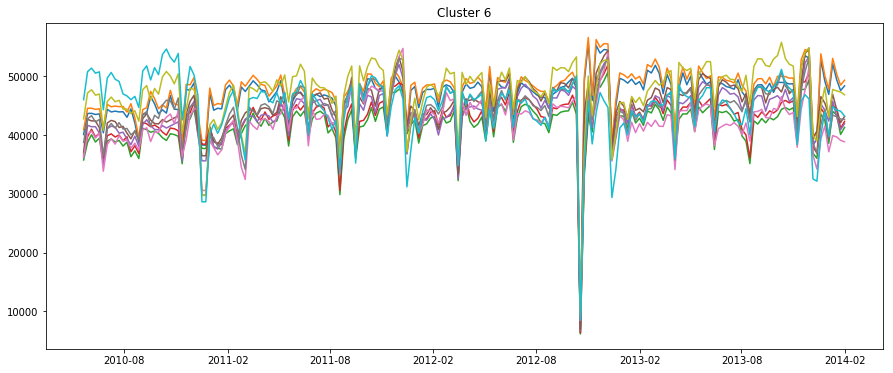

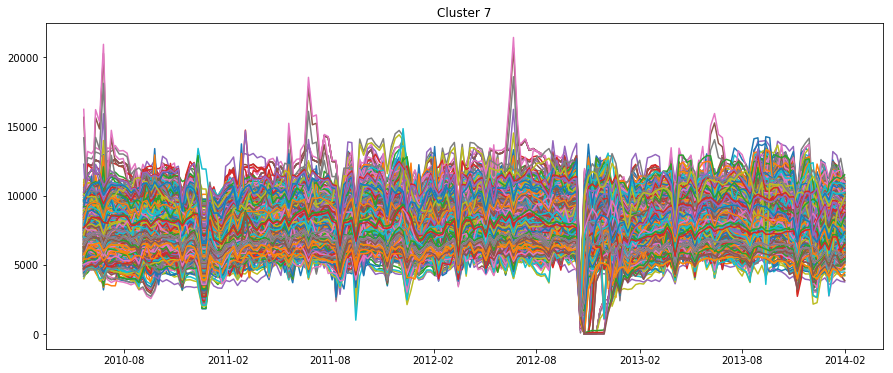

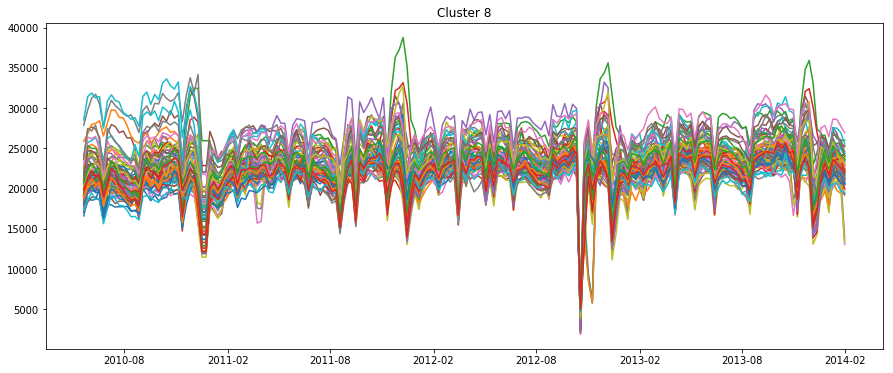

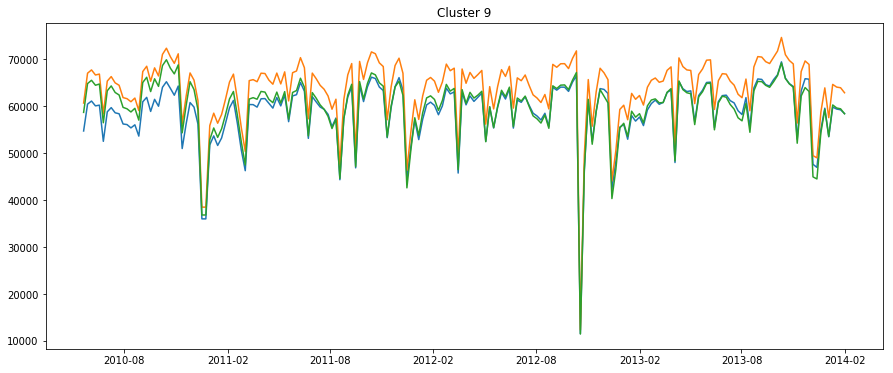

In [25]:
cldata_fft = np.apply_along_axis(calc_periodicity, 1, cldata)

kmeans = KMeans(n_clusters=10)
classes = kmeans.fit_predict(cldata_fft)

for i in np.unique(classes):
    for s in cldata[classes == i]:
        plt.plot(dates, s)
    plt.title('Cluster {}'.format(i))
    plt.show()

### Figure 8: Clusters based on the periodicity of the signal. The results don't seem much better. There seem to be a bunch of highly populated clusters mixed with some sparse clusters. There's seems to be a degree of correlation within the clusters, although the groups are too noisy to say anything conclusive.

In [26]:
tsne = TSNE(n_components=2)
U = tsne.fit_transform(cldata_norm)
plt.scatter(U[:,0], U[:,1])

KeyboardInterrupt: 

### Figure 9: TSNE dimensionality reduction of the normalized, smoothed time series. The clusters don't seem to be defined radially and therefore would not benefit greatly from KMeans. A different clustering approach that involves point affinity such as Affinity Propagation could be employed.

In [27]:
tsne = TSNE(n_components=2)
Uf = tsne.fit_transform(cldata_fft)
plt.title('TSNE Dimensionality Reduction of time series spectra')
plt.scatter(Uf[:,0], Uf[:,1]);

KeyboardInterrupt: 

### Figure 10: TSNE Dimensionality Reduction of time series spectra. It appears there are more distinct groupings of the spectra, however they are in the form of long, connect "noodles" for lack of a better word. KMeans would most likely not be able to capture this structure with high fidelity, however the results are shown below.

In [28]:
kmeans = KMeans(n_clusters=12)
classes = kmeans.fit_predict(Uf)
plt.title('Clustering for TSNE Dimensionality Reduction of time series spectra')
plt.scatter(Uf[:,0], Uf[:,1], c=classes);

NameError: name 'Uf' is not defined

### Figure 11: The KMeans clusters of the time series spectra. The clusters do not appear to be defined in a natural way judging by the visual structure of the data, however this behavior is not unexpected given the KMeans algorithm. As described above, an affinity matrix based clustering algorithm would most likely behave better.

In [ ]:
for i in np.unique(classes):
    for s in cldata_norm[classes == i][:100]:
        plt.plot(dates, s)
    plt.title('Cluster {}'.format(i))
    plt.show()

Grade: 10/10